## Imports 

In [22]:
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, KFold
from sklearn.linear_model import LogisticRegression, Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_regression, RFECV
from sklearn.pipeline import Pipeline
from numpy import sqrt


## Data preparation

In [23]:
import os
from pathlib import Path
from sklearn.model_selection import train_test_split

# 0. Baseline

## 0.1 Linear Regression without Hyperparameter Optimization or Feature Selection

In [48]:
import pandas as pd
data_train = pd.read_csv('../data/processed/X_train_lr.csv')
data_test = pd.read_csv('../data/processed/X_test_lr.csv')
data_val = pd.read_csv('../data/processed/X_val_lr.csv')

target_train = pd.read_csv('../data/processed/y_train_lr.csv')
target_test = pd.read_csv('../data/processed/y_test_lr.csv')
target_val = pd.read_csv('../data/processed/y_val_lr.csv')


In [25]:
print(f"Data mean: {data_train.mean().mean()}, Data std: {data_train.std().mean()}")

Data mean: 0.01516306220733957, Data std: 0.9856880295944443


In [26]:
print(f"Class distribution: {target_train.value_counts(normalize=True)}")

Class distribution: DRK_YN
0         0.500186
1         0.499814
Name: proportion, dtype: float64


Validation Set Performance (Baseline Logistic Regression):
AUC:        0.8038
Accuracy:   0.7270
Precision:  0.7293
Recall:     0.7216
F1 Score:   0.7254

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.73      0.73     74379
           1       0.73      0.72      0.73     74323

    accuracy                           0.73    148702
   macro avg       0.73      0.73      0.73    148702
weighted avg       0.73      0.73      0.73    148702



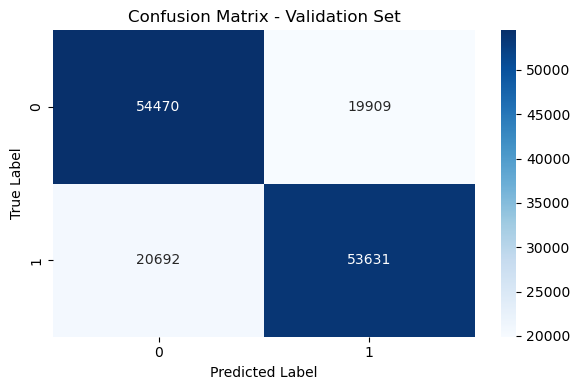

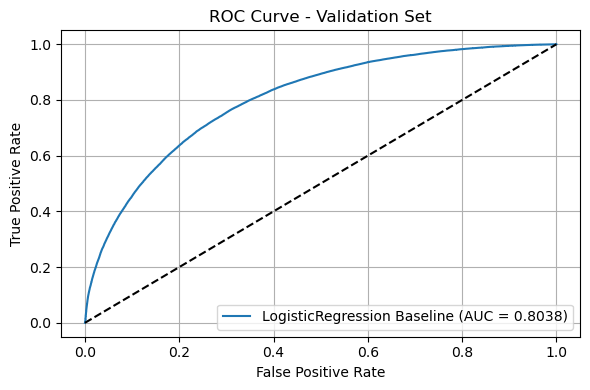

In [58]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    roc_auc_score, accuracy_score, precision_score, recall_score,
    f1_score, confusion_matrix, classification_report, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns


regressor_0 = LogisticRegression(max_iter=10000, tol=1e-4, class_weight=None)
regressor_0.fit(data_train, target_train.values.ravel())


# Predict on validation and test sets
target_val_pred = regressor_0.predict(data_val)
target_val_proba = regressor_0.predict_proba(data_val)[:, 1]

target_test_pred = regressor_0.predict(data_test)
target_test_proba = regressor_0.predict_proba(data_test)[:, 1]

val_auc = roc_auc_score(target_val, target_val_proba)
val_acc = accuracy_score(target_val, target_val_pred)
val_precision = precision_score(target_val, target_val_pred)
val_recall = recall_score(target_val, target_val_pred)
val_f1 = f1_score(target_val, target_val_pred)
conf_mat = confusion_matrix(target_val, target_val_pred)

print("Validation Set Performance (Baseline Logistic Regression):")
print(f"AUC:        {val_auc:.4f}")
print(f"Accuracy:   {val_acc:.4f}")
print(f"Precision:  {val_precision:.4f}")
print(f"Recall:     {val_recall:.4f}")
print(f"F1 Score:   {val_f1:.4f}")
print("\nClassification Report:\n", classification_report(target_val, target_val_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(target_val, target_val_proba)  
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"LogisticRegression Baseline (AUC = {val_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# 1. Random Search

Fitting 3 folds for each of 15 candidates, totalling 45 fits
Validation Set Performance (Random Search Logistic Regression):
AUC:        0.8038
Accuracy:   0.7270
Precision:  0.7293
Recall:     0.7216
F1 Score:   0.7254

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.73      0.73     74379
           1       0.73      0.72      0.73     74323

    accuracy                           0.73    148702
   macro avg       0.73      0.73      0.73    148702
weighted avg       0.73      0.73      0.73    148702



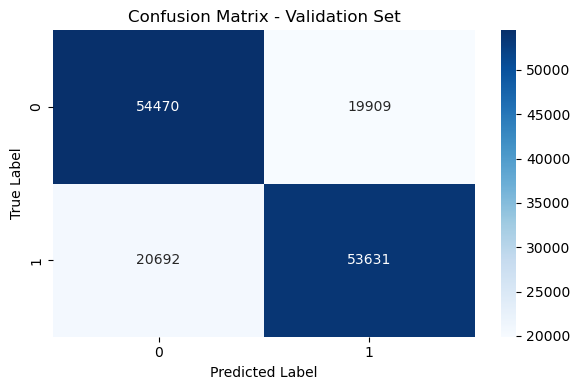

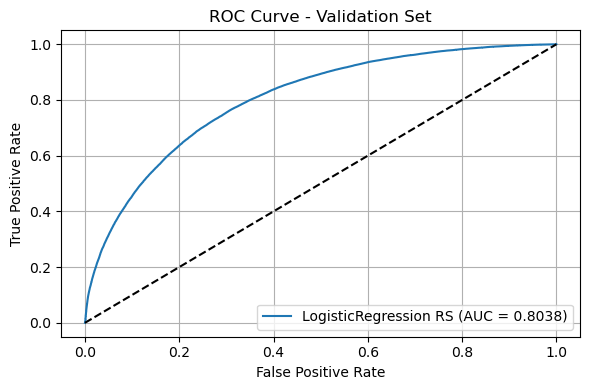

In [57]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

param_dist = {
    'C': np.linspace(0.5, 1.5, 10),  
    'penalty': ['l2'],              
    'solver': ['lbfgs', 'newton-cholesky'], 
    'max_iter': [500]                
}

regressor_1 = LogisticRegression(random_state=42)

f1_scorer = make_scorer(f1_score)

random_search = RandomizedSearchCV(
    regressor_1,
    param_distributions=param_dist,
    n_iter=15, 
    cv=3,
    scoring=f1_scorer,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

random_search.fit(data_train, target_train.values.ravel())

# Predict on validation and test sets
target_val_pred = random_search.predict(data_val)
target_val_proba = random_search.predict_proba(data_val)[:, 1]

target_test_pred = random_search.predict(data_test)
target_test_proba = random_search.predict_proba(data_test)[:, 1]

val_auc = roc_auc_score(target_val, target_val_proba)
val_acc = accuracy_score(target_val, target_val_pred)
val_precision = precision_score(target_val, target_val_pred)
val_recall = recall_score(target_val, target_val_pred)
val_f1 = f1_score(target_val, target_val_pred)
conf_mat = confusion_matrix(target_val, target_val_pred)

print("Validation Set Performance (Random Search Logistic Regression):")
print(f"AUC:        {val_auc:.4f}")
print(f"Accuracy:   {val_acc:.4f}")
print(f"Precision:  {val_precision:.4f}")
print(f"Recall:     {val_recall:.4f}")
print(f"F1 Score:   {val_f1:.4f}")
print("\nClassification Report:\n", classification_report(target_val, target_val_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(target_val, target_val_proba)  
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"LogisticRegression RS (AUC = {val_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



# 2. Grid Search

Fitting 5 folds for each of 56 candidates, totalling 280 fits
Validation Set Performance (Grid Search Logistic Regression):
AUC:        0.8038
Accuracy:   0.7269
Precision:  0.7292
Recall:     0.7215
F1 Score:   0.7254

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.73      0.73     74379
           1       0.73      0.72      0.73     74323

    accuracy                           0.73    148702
   macro avg       0.73      0.73      0.73    148702
weighted avg       0.73      0.73      0.73    148702



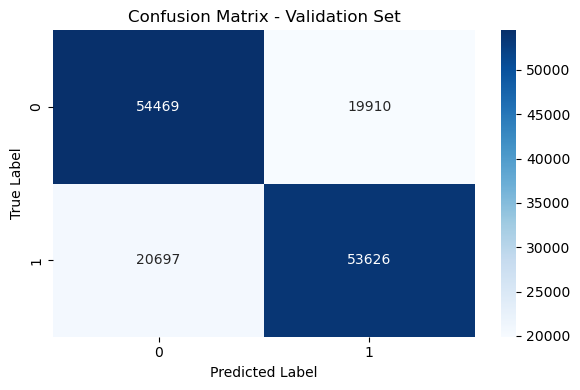

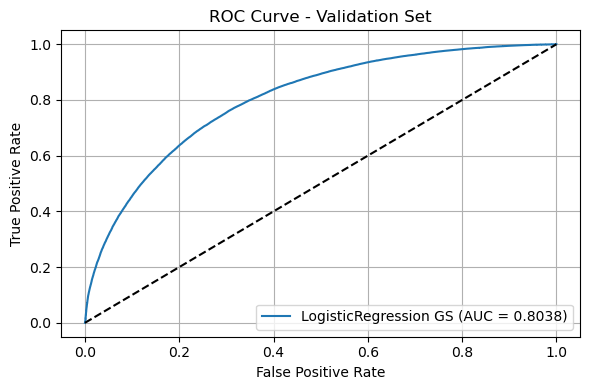

In [59]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import numpy as np

logreg_pipe = Pipeline([
   ('logreg', LogisticRegression(
        random_state=42,
        class_weight=None,
        max_iter=10000,       
        tol=1e-3,   
        warm_start=False     
    ))
])

param_grid = [
    {
        'logreg__penalty': ['l1', 'l2'],
        'logreg__C': np.logspace(-3, 3, 7), 
        'logreg__solver': ['liblinear', 'saga']  
    },
    {
        'logreg__penalty': ['l2'],
        'logreg__C': np.logspace(-3, 3, 7),
        'logreg__solver': ['lbfgs', 'newton-cg', 'sag', 'newton-cholesky']  
    }
]

grid_search = GridSearchCV(
    estimator=logreg_pipe,
    param_grid=param_grid,
    scoring={
        'accuracy': 'accuracy',
        'f1': f1_scorer,
        'precision': make_scorer(precision_score, average='binary'),
        'recall': make_scorer(recall_score, average='binary')
    },
    refit='f1',
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42), 
    n_jobs=-1,
    verbose=1,
    error_score='raise'
)

grid_search.fit(data_train, target_train.values.ravel())

# Predict on validation and test sets
target_val_pred =grid_search.predict(data_val)
target_val_proba = grid_search.predict_proba(data_val)[:, 1]

target_test_pred = grid_search.predict(data_test)
target_test_proba = grid_search.predict_proba(data_test)[:, 1]

val_auc = roc_auc_score(target_val, target_val_proba)
val_acc = accuracy_score(target_val, target_val_pred)
val_precision = precision_score(target_val, target_val_pred)
val_recall = recall_score(target_val, target_val_pred)
val_f1 = f1_score(target_val, target_val_pred)
conf_mat = confusion_matrix(target_val, target_val_pred)

print("Validation Set Performance (Grid Search Logistic Regression):")
print(f"AUC:        {val_auc:.4f}")
print(f"Accuracy:   {val_acc:.4f}")
print(f"Precision:  {val_precision:.4f}")
print(f"Recall:     {val_recall:.4f}")
print(f"F1 Score:   {val_f1:.4f}")
print("\nClassification Report:\n", classification_report(target_val, target_val_pred))

plt.figure(figsize=(6, 4))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

fpr, tpr, _ = roc_curve(target_val, target_val_proba)  
plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f"LogisticRegression GS (AUC = {val_auc:.4f})")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve - Validation Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


